In [1]:
'''
  This program shell reads phrase data for the kaggle phrase sentiment classification problem.
  The input to the program is the path to the kaggle directory "corpus" and a limit number.
  The program reads all of the kaggle phrases, and then picks a random selection of the limit number.
  It creates a "phrasedocs" variable with a list of phrases consisting of a pair
    with the list of tokenized words from the phrase and the label number from 1 to 4
  It prints a few example phrases.
  In comments, it is shown how to get word lists from the two sentiment lexicons:
      subjectivity and LIWC, if you want to use them in your features
  Your task is to generate features sets and train and test a classifier.

  This version uses cross-validation with the Naive Bayes classifier in NLTK.
  It computes the evaluation measures of precision, recall and F1 measure for each fold.
  It also averages across folds and across labels.
'''
# open python and nltk packages needed for processing
import os
import sys
import random
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [2]:
## define feature definition functions
# this function define features (keywords) of a document for a BOW/unigram baseline
# each feature is 'V_(keyword)' and is true or false depending
# on whether that keyword is in the document

def document_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features



#list of negation words to create a negation feature:
negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 'rarely', 
                 'seldom', 'neither', 'nor']


# Creating the NOT features function
def NOT_features(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features

#Defining the POS features function
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [3]:
## cross-validation ##
# this function takes the number of folds, the feature sets and the labels
# it iterates over the folds, using different sections for training and testing in turn
#   it prints the performance for each fold and the average performance at the end
def cross_validation_PRF(num_folds, featuresets, labels):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    # for the number of labels - start the totals lists with zeroes
    num_labels = len(labels)
    total_precision_list = [0] * num_labels
    total_recall_list = [0] * num_labels
    total_F1_list = [0] * num_labels

    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round to produce the gold and predicted labels
        goldlist = []
        predictedlist = []
        for (features, label) in test_this_round:
            goldlist.append(label)
            predictedlist.append(classifier.classify(features))

        # computes evaluation measures for this fold and
        #   returns list of measures for each label
        print('Fold', i)
        (precision_list, recall_list, F1_list) \
                  = eval_measures(goldlist, predictedlist, labels)
        # take off triple string to print precision, recall and F1 for each fold
        '''
        print('\tPrecision\tRecall\t\tF1')
        # print measures for each label
        for i, lab in enumerate(labels):
            print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
              "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
        '''
        # for each label add to the sums in the total lists
        for i in range(num_labels):
            # for each label, add the 3 measures to the 3 lists of totals
            total_precision_list[i] += precision_list[i]
            total_recall_list[i] += recall_list[i]
            total_F1_list[i] += F1_list[i]

    # find precision, recall and F measure averaged over all rounds for all labels
    # compute averages from the totals lists
    precision_list = [tot/num_folds for tot in total_precision_list]
    recall_list = [tot/num_folds for tot in total_recall_list]
    F1_list = [tot/num_folds for tot in total_F1_list]
    # the evaluation measures in a table with one row per label
    print('\nAverage Precision\tRecall\t\tF1 \tPer Label')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
    
    # print macro average over all labels - treats each label equally
    print('\nMacro Average Precision\tRecall\t\tF1 \tOver All Labels')
    print('\t', "{:10.3f}".format(sum(precision_list)/num_labels), \
          "{:10.3f}".format(sum(recall_list)/num_labels), \
          "{:10.3f}".format(sum(F1_list)/num_labels))

    # for micro averaging, weight the scores for each label by the number of items
    #    this is better for labels with imbalance
    # first intialize a dictionary for label counts and then count them
    label_counts = {}
    for lab in labels:
      label_counts[lab] = 0 
    # count the labels
    for (doc, lab) in featuresets:
      label_counts[lab] += 1
    # make weights compared to the number of documents in featuresets
    num_docs = len(featuresets)
    label_weights = [(label_counts[lab] / num_docs) for lab in labels]
    print('\nLabel Counts', label_counts)
    #print('Label weights', label_weights)
    # print macro average over all labels
    print('Micro Average Precision\tRecall\t\tF1 \tOver All Labels')
    precision = sum([a * b for a,b in zip(precision_list, label_weights)])
    recall = sum([a * b for a,b in zip(recall_list, label_weights)])
    F1 = sum([a * b for a,b in zip(F1_list, label_weights)])
    print( '\t', "{:10.3f}".format(precision), \
      "{:10.3f}".format(recall), "{:10.3f}".format(F1))
    



In [4]:
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output: returns lists of precision, recall and F1 for each label
#      (for computing averages across folds and labels)
def eval_measures(gold, predicted, labels):
    
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []

    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        # for small numbers, guard against dividing by zero in computing measures
        if (TP == 0) or (FP == 0) or (FN == 0):
          recall_list.append (0)
          precision_list.append (0)
          F1_list.append(0)
        else:
          recall = TP / (TP + FP)
          precision = TP / (TP + FN)
          recall_list.append(recall)
          precision_list.append(precision)
          F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    return (precision_list, recall_list, F1_list)

## function to read kaggle training file, train and test a classifier 
def processkaggle(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  
  dirPath0 = os.getcwd()
  dirPath = dirPath0+'/corpus'
  print('dirPath in processkaggle function: ', dirPath)
  
  f = open('./corpus/train.tsv', 'r')
  # loop over lines in the file and use the first limit of them
  phrasedata = []
  for line in f:
    # ignore the first line starting with Phrase and read all lines
    if (not line.startswith('Phrase')):
      # remove final end of line character
      line = line.strip()
      # each line has 4 items separated by tabs
      # ignore the phrase and sentence ids, and keep the phrase and sentiment
      phrasedata.append(line.split('\t')[2:4])
  
  # pick a random sample of length limit because of phrase overlapping sequences
  random.shuffle(phrasedata)
  phraselist = phrasedata[:limit]

  print('Read', len(phrasedata), 'phrases, using', len(phraselist), 'random phrases')
  
  # create list of phrase documents as (list of words, label)
  phrasedocs = []
  # add all the phrases

  # each phrase has a list of tokens and the sentiment label (from 0 to 4)
  ### bin to only 3 categories for better performance
  for phrase in phraselist:
    tokens = nltk.word_tokenize(phrase[0])
    phrasedocs.append((tokens, int(phrase[1])))

  # possibly filter tokens
  # lowercase - each phrase is a pair consisting of a token list and a label
  docs = []
  for phrase in phrasedocs:
    lowerphrase = ([w.lower() for w in phrase[0]], phrase[1])
    docs.append (lowerphrase)
  # print a few
  for phrase in docs[:10]:
    print (phrase)

  # continue as usual to get all words and create word features
  all_words_list = [word for (sent,cat) in docs for word in sent]
  all_words = nltk.FreqDist(all_words_list)
  print(len(all_words))
    

  # get the 1500 most frequently appearing keywords in the corpus
  word_items = all_words.most_common(1500)
  word_features = [word for (word,count) in word_items]

  stopwords = nltk.corpus.stopwords.words('english')

  # remove some negation words 
  negationwords.extend(['ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'])

  newstopwords = [word for word in stopwords if word not in negationwords]
  # remove stop words from the all words list
  new_all_words_list = [word for (sent,cat) in docs for word in sent if word not in newstopwords]

  # continue to define a new all words dictionary, get the 1500 most common as new_word_features
  new_all_words = nltk.FreqDist(new_all_words_list)
  new_word_items = new_all_words.most_common(1500)

  new_word_features = [word for (word,count) in new_word_items]

  #Creating Bigram features
  finder = BigramCollocationFinder.from_words(all_words_list)
  # define the top 500 bigrams using the chi squared measure
  bigram_features = finder.nbest(bigram_measures.chi_sq, 500)

  def bigram_document_features(document, word_features, bigram_features):
      document_words = set(document)
      document_bigrams = nltk.bigrams(document)
      features = {}
      for word in word_features:
          features['V_{}'.format(word)] = (word in document_words)
      for bigram in bigram_features:
          features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
      return features

  # feature sets from feature definition functions above
  featuresets = [(document_features(d, word_features), c) for (d, c) in docs]
  negfeaturesets = [(NOT_features(d, word_features, negationwords), c) for (d, c) in docs]
  bigramfeaturesets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in docs]
  POSfeaturesets = [(POS_features(d, new_word_features), c) for (d, c) in docs]
  # train classifier and show performance in cross-validation
  # make a list of labels
  label_list = [c for (d,c) in docs]
  labels = list(set(label_list))    # gets only unique labels
  num_folds = 10

  #printing cross validation results for every feature and combination feature 
  #Unigram or Bag-of-Words (BOW) features; this is the baseline:
  print("\nOriginal Featureset")
  cross_validation_PRF(num_folds, featuresets, labels)
  #Bigrams
  print("\nBigrams Featureset")
  cross_validation_PRF(num_folds, bigramfeaturesets, labels)
  #Negation -- SHOULD BE CREATED
  print("\nNegated Featureset")
  cross_validation_PRF(num_folds, negfeaturesets, labels)
  #POS features -- SHOULD BE CREATED
  print("\nPOS Featureset")
  cross_validation_PRF(num_folds, POSfeaturesets, labels)

In [5]:
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output: returns lists of precision, recall and F1 for each label
#      (for computing averages across folds and labels)
def eval_measures(gold, predicted, labels):
    
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []

    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        # for small numbers, guard against dividing by zero in computing measures
        if (TP == 0) or (FP == 0) or (FN == 0):
          recall_list.append (0)
          precision_list.append (0)
          F1_list.append(0)
        else:
          recall = TP / (TP + FP)
          precision = TP / (TP + FN)
          recall_list.append(recall)
          precision_list.append(precision)
          F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    return (precision_list, recall_list, F1_list)

## function to read kaggle training file, train and test a classifier 
def processkaggle(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  
  dirPath0 = os.getcwd()
  dirPath = dirPath0+'/corpus'
  print('dirPath in processkaggle function: ', dirPath)
  
  f = open('./corpus/train.tsv', 'r')
  # loop over lines in the file and use the first limit of them
  phrasedata = []
  for line in f:
    # ignore the first line starting with Phrase and read all lines
    if (not line.startswith('Phrase')):
      # remove final end of line character
      line = line.strip()
      # each line has 4 items separated by tabs
      # ignore the phrase and sentence ids, and keep the phrase and sentiment
      phrasedata.append(line.split('\t')[2:4])
  
  # pick a random sample of length limit because of phrase overlapping sequences
  random.shuffle(phrasedata)
  phraselist = phrasedata[:limit]

  print('Read', len(phrasedata), 'phrases, using', len(phraselist), 'random phrases')
  
  # create list of phrase documents as (list of words, label)
  phrasedocs = []
  # add all the phrases

  # each phrase has a list of tokens and the sentiment label (from 0 to 4)
  ### bin to only 3 categories for better performance
  for phrase in phraselist:
    tokens = nltk.word_tokenize(phrase[0])
    phrasedocs.append((tokens, int(phrase[1])))

  # possibly filter tokens
  # lowercase - each phrase is a pair consisting of a token list and a label
  docs = []
  for phrase in phrasedocs:
    lowerphrase = ([w.lower() for w in phrase[0]], phrase[1])
    docs.append (lowerphrase)
  # print a few
  for phrase in docs[:10]:
    print (phrase)

  # continue as usual to get all words and create word features
  all_words_list = [word for (sent,cat) in docs for word in sent]
  all_words = nltk.FreqDist(all_words_list)
  print(len(all_words))
    

  # get the 1500 most frequently appearing keywords in the corpus
  word_items = all_words.most_common(1500)
  word_features = [word for (word,count) in word_items]

  stopwords = nltk.corpus.stopwords.words('english')

  # remove some negation words 
  negationwords.extend(['ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'])

  newstopwords = [word for word in stopwords if word not in negationwords]
  # remove stop words from the all words list
  new_all_words_list = [word for (sent,cat) in docs for word in sent if word not in newstopwords]

  # continue to define a new all words dictionary, get the 1500 most common as new_word_features
  new_all_words = nltk.FreqDist(new_all_words_list)
  new_word_items = new_all_words.most_common(1500)

  new_word_features = [word for (word,count) in new_word_items]

  #Creating Bigram features
  finder = BigramCollocationFinder.from_words(all_words_list)
  # define the top 500 bigrams using the chi squared measure
  bigram_features = finder.nbest(bigram_measures.chi_sq, 500)

  def bigram_document_features(document, word_features, bigram_features):
      document_words = set(document)
      document_bigrams = nltk.bigrams(document)
      features = {}
      for word in word_features:
          features['V_{}'.format(word)] = (word in document_words)
      for bigram in bigram_features:
          features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)    
      return features

  # feature sets from feature definition functions above
  featuresets = [(document_features(d, word_features), c) for (d, c) in docs]
  negfeaturesets = [(NOT_features(d, word_features, negationwords), c) for (d, c) in docs]
  bigramfeaturesets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in docs]
  POSfeaturesets = [(POS_features(d, new_word_features), c) for (d, c) in docs]
  # train classifier and show performance in cross-validation
  # make a list of labels
  label_list = [c for (d,c) in docs]
  labels = list(set(label_list))    # gets only unique labels
  num_folds = 10

  #printing cross validation results for every feature and combination feature 
  #Unigram or Bag-of-Words (BOW) features; this is the baseline:
  print("\nOriginal Featureset")
  cross_validation_PRF(num_folds, featuresets, labels)
  #Bigrams
  print("\nBigrams Featureset")
  cross_validation_PRF(num_folds, bigramfeaturesets, labels)
  #Negation -- SHOULD BE CREATED
  print("\nNegated Featureset")
  cross_validation_PRF(num_folds, negfeaturesets, labels)
  #POS features -- SHOULD BE CREATED
  print("\nPOS Featureset")
  cross_validation_PRF(num_folds, POSfeaturesets, labels)

In [6]:
"""
commandline interface takes a directory name with kaggle subdirectory for train.tsv
   and a limit to the number of kaggle phrases to use
It then processes the files and trains a kaggle movie review sentiment classifier.

"""
dirPath0 = os.getcwd()
dirPath = dirPath0+'/train.tsv'
print('dirpath in program execution code (last line in the code): ', dirPath)
processkaggle(dirPath, 400)

dirpath in program execution code (last line in the code):  C:\Users\maria/train.tsv
dirPath in processkaggle function:  C:\Users\maria/corpus
Read 156060 phrases, using 400 random phrases
(['the', 'sight', 'of', 'the', 'name', 'bruce', 'willis'], 2)
(['about', 'a', 'contract', 'on', 'his', 'life'], 2)
(['in', 'her', 'feature', 'film', 'acting', 'debut', 'as', 'amy'], 2)
(['something', 'in', 'full', 'frontal'], 2)
(['erratic', 'dramedy'], 1)
(['formulaic', ','], 1)
(['can', 'not', 'be', 'revived', '.'], 1)
(['by', 'the', 'two', 'daughters'], 2)
(['all', 'comedy', 'is', 'subversive', ',', 'but', 'this', 'unrelenting', 'bleak', 'insistence', 'on', 'opting', 'out', 'of', 'any', 'opportunity', 'for', 'finding', 'meaning', 'in', 'relationships', 'or', 'work', 'just', 'becomes', 'sad'], 0)
(['to', 'blame', 'for', 'all', 'that'], 2)
1357

Original Featureset
Each fold size: 40
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9

Average Precision	Recall		F1 	Per Label
0 	   

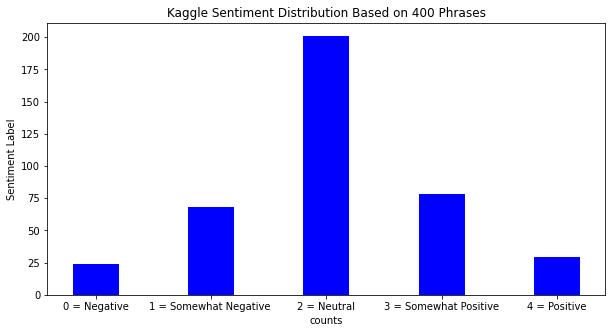

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns   
# creating the dataset
data = {'0 = Negative':24,'1 = Somewhat Negative ': 68,'2 = Neutral':201, '3 = Somewhat Positive':78, '4 = Positive':29}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Sentiment Label")
plt.title("Kaggle Sentiment Distribution Based on 400 Phrases")
plt.show()

In [13]:
import matplotlib.pyplot as plt
Sentiment_count = dirPath.groupby('Sentiment').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['Phrase'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

AttributeError: 'str' object has no attribute 'groupby'

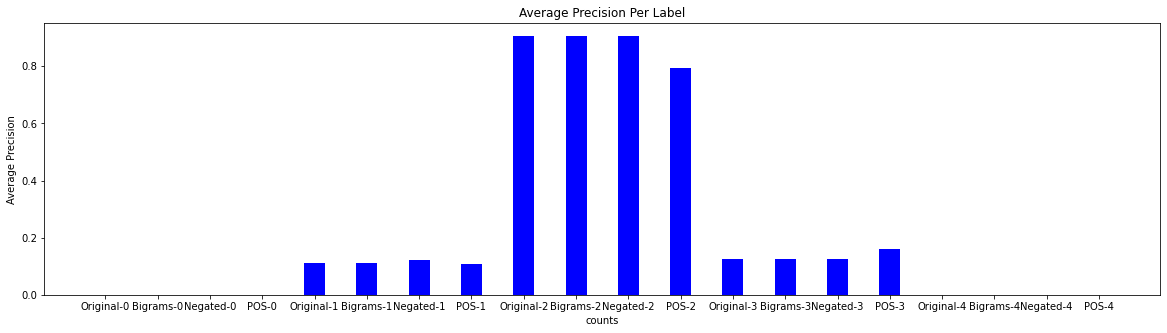

In [21]:

# creating the dataset
data = {'Original-0':0,'Bigrams-0':0,'Negated-0':0, 'POS-0':0, 'Original-1':0.112,'Bigrams-1':0.112,'Negated-1':0.121, 'POS-1':0.108,
        'Original-2':0.906,'Bigrams-2':0.906,'Negated-2':0.906, 'POS-2':0.795, 'Original-3':0.124,'Bigrams-3':0.124,'Negated-3':0.124, 
        'POS-3':0.161,'Original-4':0,'Bigrams-4':0,'Negated-4':0, 'POS-4':0 }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Average Precision")
plt.title("Average Precision Per Label")
plt.show()

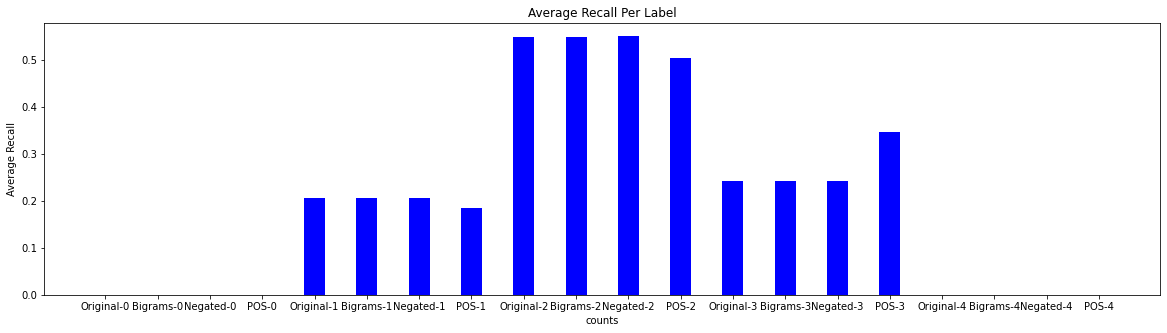

In [22]:

# creating the dataset
data = {'Original-0':0,'Bigrams-0':0,'Negated-0':0, 'POS-0':0, 
        'Original-1':0.205,'Bigrams-1':0.205,'Negated-1':0.205, 'POS-1':0.185,
        'Original-2':0.549,'Bigrams-2':0.549,'Negated-2':0.551, 'POS-2':0.503, 
        'Original-3':0.242,'Bigrams-3':0.242,'Negated-3':0.242, 'POS-3':0.347,
        'Original-4':0,'Bigrams-4':0,'Negated-4':0, 'POS-4':0 }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Average Recall")
plt.title("Average Recall Per Label")
plt.show()

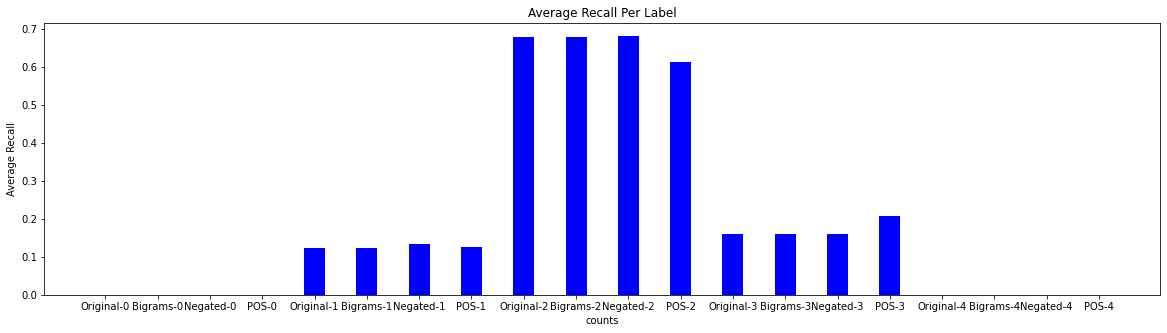

In [23]:

# creating the dataset
data = {'Original-0':0,'Bigrams-0':0,'Negated-0':0, 'POS-0':0, 
        'Original-1':0.124,'Bigrams-1':0.124,'Negated-1':0.133, 'POS-1':0.125,
        'Original-2':0.680,'Bigrams-2':0.680,'Negated-2':0.682, 'POS-2':0.613, 
        'Original-3':0.160,'Bigrams-3':0.160,'Negated-3':0.160, 'POS-3':0.207,
        'Original-4':0,'Bigrams-4':0,'Negated-4':0, 'POS-4':0 }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Average Recall")
plt.title("Average Recall Per Label")
plt.show()

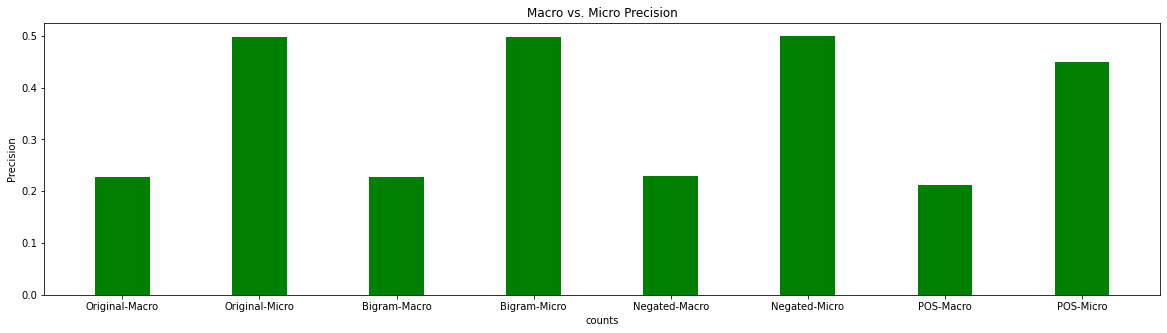

In [28]:

# creating the dataset
data = {'Original-Macro':0.228,'Original-Micro':0.498,'Bigram-Macro':0.228, 'Bigram-Micro':0.498, 
        'Negated-Macro':0.230, 'Negated-Micro':0.500, 'POS-Macro':0.213, 'POS-Micro':0.449 }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Precision")
plt.title("Macro vs. Micro Precision")
plt.show()

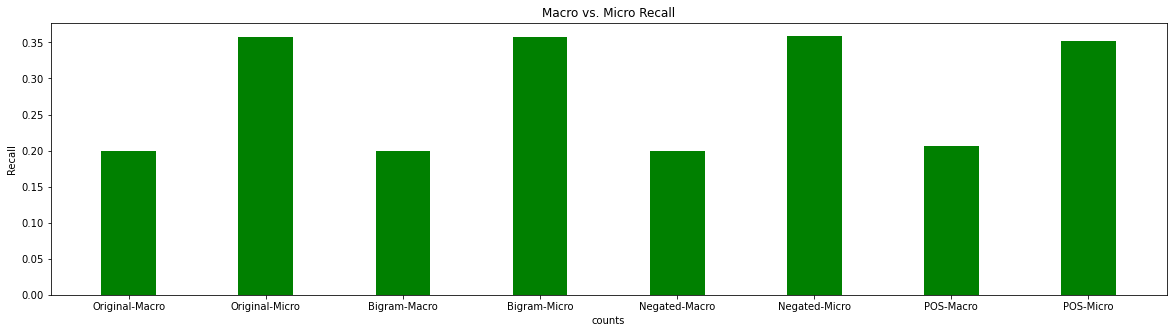

In [29]:
# creating the dataset
data = {'Original-Macro':0.199,'Original-Micro':0.358,'Bigram-Macro':0.199, 'Bigram-Micro':0.358, 
        'Negated-Macro':0.199, 'Negated-Micro':0.359, 'POS-Macro':0.207, 'POS-Micro':0.352 }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Recall")
plt.title("Macro vs. Micro Recall")
plt.show()

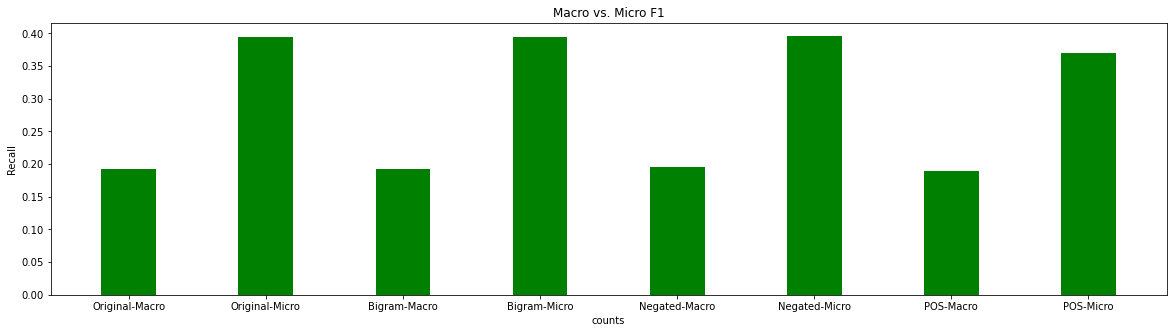

In [30]:
# creating the dataset
data = {'Original-Macro':0.193,'Original-Micro':0.394,'Bigram-Macro':0.193, 'Bigram-Micro':0.394, 
        'Negated-Macro':0.195, 'Negated-Micro':0.396, 'POS-Macro':0.189, 'POS-Micro':0.370 }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.4)
 
plt.xlabel("counts")
plt.ylabel("Recall")
plt.title("Macro vs. Micro F1")
plt.show()